# Imports

In [101]:
import json
import random
import os
import time

import cv2
import cyvlfeat
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
from skimage.draw import line_nd
from skimage import filters
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import haar_like_feature_coord
import torch
import torchvision

from ipywidgets import *
from IPython.display import display

device = "cpu"

%matplotlib inline

# Function Definitions

## Helper Functions 

In [182]:
def save_config(filename, func_stack, config_stack):
    if not filename.endswith(".json"):
        filename += ".json"
        
    exp = {
        "func_stack": func_stack,
        "config_stack": config_stack,
    }
    
    with open(filename, "w") as file:
        json.dump(exp, file, indent=4)
        
    print(filename, "is created.")
    
def load_config(json_content, func_stack, config_stack):
    print("Previous functions:")
    pprint(func_stack)
    print("Previous configurations:")
    pprint(config_stack)
    
    exp = json.loads(json_content)
    func_stack[:] = exp["func_stack"]
    config_stack[:] = exp["config_stack"]
    
    print("Current functions:")
    pprint(func_stack)
    print("Current configurations:")
    pprint(config_stack)

def update_log(log, stack):
    with log:
        log.clear_output()
        for i, func in enumerate(stack):
            print("{}: {}".format(i, func))

def push(stack, log, e):
    stack.append(e.description)
    update_log(log, stack)

def pop(stack, log):
    if len(stack) > 0:
        stack.pop()
    update_log(log, stack)
                
def compute_line_pixels(shape, rho, theta):
    # TODO: Fix the bug
    # Compute intercepts for upper and lower edges, compute pixels of the line passing through them
    top = 0
    bottom = shape[0] - 1
    left = 0
    right = shape[1] - 1
    
    # TODO: remove
    if theta > np.pi:
        print("Warning!")
        print("Rho:", rho)
        print("Angle:", np.rad2deg(theta))
    elif theta < 0:
        print("Warning!")
        print("Rho:", rho)
        print("Angle:", np.rad2deg(theta))
    
    # Horizontal line (parallel to x-axis)
    if np.isclose(theta, np.pi/2):
        p1 = (np.abs(rho), left)
        p2 = (np.abs(rho), right)
    
    # Vertical line (parallel to y-axis)
    elif np.isclose(theta, 0):
        p1 = (top, np.abs(rho))
        p2 = (bottom, np.abs(rho))
    
    # Line with arbitrary slopes
    else:
        p1 = (top, rho/np.cos(theta))
        p2 = (bottom, (rho-bottom*np.sin(theta))/np.cos(theta))
    
    # TODO: remove try-except check later
    try:
        pixels = line_nd(p1, p2, endpoint=True)
    except Exception as e:
        print(p1)
        print(p2)
        print(rho)
        print(np.rad2deg(theta))
        print(np.cos(theta))
        print(np.sin(theta))
        raise e
    
    # Convert NumPy indices to OpenCV coordinates for proper drawing
    cv_y, cv_x = pixels
    coords = np.stack((cv_x.reshape(-1, 1), cv_y.reshape(-1, 1)), axis=2)
    
    # Take 1st quadrant coordinates only
    coords = coords[coords.min(axis=2)>=0]
    return coords

def convert_coord2mask(shape, indices):
    """Convert line coordinates of a single line into a binary mask"""
    indices = np.array(indices).reshape(shape[0], 2) # Ensure shape (H, 2)
    col, row = np.hsplit(indices, 2)                 # OpenCV coords -> NumPy indices
    mask = np.zeros(shape[:2], dtype=np.uint8)
    mask[row, col] = 255
    return mask

def set_roi(image, num_corners=5):
    """Choose corners for ROI interactively, returns ROI corners in pixel coordinates"""
    def info(msg):
        plt.title(msg, fontsize=15)
        plt.draw()
        
    roi_corners = []
    handler = plt.imshow(image)
    fig_manager = plt.get_current_fig_manager()
    fig_manager.window.showMaximized()

    info('Click to start...')    
    plt.waitforbuttonpress()
    
    info('Select {} corners with mouse.'.format(num_corners))
    roi_corners = np.array(plt.ginput(num_corners, timeout=-1))

    C = image.shape[2] if len(image.shape) == 3 else 1
    black = (0,) * C
    roi_corners = np.rint(roi_corners).astype(np.int32)
    image = cv2.polylines(image.copy(), [roi_corners], isClosed=True, color=black)
    handler.set_data(image)
        
    info('Click to quit...')
    plt.waitforbuttonpress()
    
    return roi_corners

def apply_functions(image, func_stack, config_stack):
    show_image(image)
    for i in range(len(func_stack)):
        key = func_stack[i]
        image = funcs[key](image, **config_stack[i])
    return image
    
def show_image(image, h=10, w=10, cmap=None):
    plt.figure(figsize=(w,h))
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def show_contours(image, contours, contourIdx='all', cmap=None):
    # To draw all the contours in the image, set contourIdx to -1
    if contourIdx == 'all':
        contourIdx = -1
        
    C = image.shape[2] if len(image.shape) == 3 else 1
    white = (255,) * C

    image = cv2.drawContours(image, contours, contourIdx=contourIdx, color=white, thickness=1)
    show_image(image, cmap=cmap)
    
def show_lines(image, params, cmap=None):
    for p in params:
        rho, theta = p.ravel()
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(image, (x1,y1), (x2,y2), color=(255,0,0), thickness=1)
    
    show_image(image, cmap=cmap)
    
def show_overlay(image, mask):
    """Overlay a binary mask on top of RGB image"""
    overlaid = image.copy()
    overlaid[np.where(mask == 255)] = 0
    show_image(overlaid)

def show_image_pairs(left, right, h=15, w=15):
    f, ax = plt.subplots(1,2)
    f.set_figheight(h)
    f.set_figwidth(w)
    ax[0].imshow(left)
    ax[1].imshow(right)
    plt.show()

## UI Callback Functions

Register a callback for configuration of image processing methods here if needed.

In [180]:
def threshold_config(thresh=127, maxval=255, type=0):
    return {"thresh": thresh, "maxval": maxval, "type": type}

def adaptive_threshold_config(maxValue, adaptiveMethod, thresholdType, blockSize, C):
    return {"maxValue": maxValue, "adaptiveMethod": adaptiveMethod, "thresholdType": thresholdType, "blockSize": blockSize, "C": C}

def spatial_threshold_config(min_x=0, max_x=640, min_y=0, max_y=480):
    return {"range_x": (min_x, max_x), "range_y": (min_y, max_y)}

def avg_blur_config(ksize):
    return {"ksize": ksize}

def median_blur_config(ksize):
    return {"ksize": ksize}

def bilateral_filter_config(d, sigmaColor, sigmaSpace):
    return {"d": d, "sigmaColor": sigmaColor, "sigmaSpace": sigmaSpace}

def gaussian_blur_config(ksize=5, sigmaX=10):
    return {"ksize": (ksize, ksize), "sigmaX": sigmaX}

def laplacian_config(ksize):
    return {"ksize": ksize}
    
def sobelv_config(ksize=5):
    return {"ksize": ksize}
    
def sobelh_config(ksize=5):
    return {"ksize": ksize}

def canny_config(threshold1=50, threshold2=100):
    return {"threshold1": threshold1, "threshold2": threshold2}

def hough_line_config(average=True, threshold=200, min_theta=0, max_theta=180):
    return {"average": average, "threshold": threshold, "min_theta": np.deg2rad(min_theta), "max_theta": np.deg2rad(max_theta)}

## Image Processing Functions

Register image processing functions to be used here.

In [199]:
def convert_grayscale(image, visualize=True, **kwargs): # **kwargs is ignored
    """Takes an RGB (3 channel) image, returns the grayscale image (1 channel)"""
    print("Converting to grayscale")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if visualize:
        show_image(image, cmap="gray")
    return image

def enhance_contrast(image, visualize=True, **kwargs): # **kwargs is ignored
    print("Enhancing contrast")
    image = cv2.equalizeHist(image)
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_threshold(gray_img, visualize=True, **kwargs):
    """Takes grayscale image, returns thresholded version."""
    print("Applying standard threshold with args:", kwargs)
    _retval, gray_img = cv2.threshold(gray_img, **kwargs)
    if visualize:
        show_image(gray_img, cmap="gray")
    return gray_img

def apply_adaptive_threshold(gray_img, **kwargs):
    """Takes grayscale image, returns thresholded version."""
    print("Applying adaptive threshold with args:", kwargs)
    return cv2.adaptiveThreshold(gray_img, **kwargs)

def apply_spatial_threshold(image, visualize=True, **kwargs):
    """Takes an image, crop certain region, set rest to zero."""
    print("Applying spatial threshold with args:", kwargs)
    
    h, w = image.shape[0:2]
    
    range_x = kwargs.get("range_x", (w, 0))
    range_y = kwargs.get("range_y", (0, h))
    
    assert range_x[0] <= range_x[1],\
        "min_x({}) cannot be greater than max_x({})".format(*range_x)
    
    assert range_x[1] <= w,\
        "Input: {}, Image Width: {}".format(range_x[1], w)
    
    assert range_x[0] >= 0 and range_x[1] >= 0,\
        "Input: {} must contain positive integer".format(range_x)
    
    assert range_y[0] <= range_y[1],\
        "min_y({}) cannot be greater than max_y({})".format(*range_y)
    
    assert range_y[1] <= h,\
        "Input: {}, Image Height: {}".format(range_y[1], h)
    
    assert range_y[0] >= 0 and range_y[1] >= 0,\
        "Input: {} must contain positive integer".format(range_y)
        
    new_image = np.zeros_like(image)
    crop = image[range_y[0]:range_y[1], range_x[0]:range_x[1]]
    new_image[range_y[0]:range_y[1], range_x[0]:range_x[1]] = crop
    
    if visualize:
        show_image(new_image)
    
    return new_image

def apply_roi_threshold(image, visualize=True, **kwargs):
    """Mask out ROI, return image as well as pixel coordinates for ROI corners"""
    print("Applying ROI threshold with args:", kwargs)
    C = image.shape[2] if len(image.shape) == 3 else 1
    white = (255,) * C
    mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.fillConvexPoly(mask, kwargs["roi_corners"], color=white)
    image = cv2.bitwise_and(image, mask)

    if visualize:
        show_image(image)
        
    return image

def apply_filter(image, kernel):
    return cv2.filter2D(image, ddepth=-1, kernel=kernel)

def apply_avg_blur(image, visualize=True, **kwargs):
    print("Applying average blur with args:", kwargs)
    image = cv2.blur(image, **kwargs)
    if visualize:
        show_image(image)
    return image

def apply_median_blur(image, visualize=True, **kwargs):
    print("Applying median blur with args:", kwargs)
    image = cv2.medianBlur(image, **kwargs)
    if visualize:
        show_image(image)
    return image

def apply_bilateral_filter(image, visualize=True, **kwargs):
    print("Applying bilateral filter with args:", kwargs)
    image = cv2.bilateralFilter(image, **kwargs)
    if visualize:
        show_image(image)
    return image

def apply_gaussian_blur(image, visualize=True, **kwargs):
    print("Applying Gaussian blur with args:", kwargs)
    image = cv2.GaussianBlur(image, **kwargs)
    if visualize:
        show_image(image)
    return image

def apply_laplacian(image, visualize=True, **kwargs): 
    print("Applying Laplacian filter for vertical and horizontal edges with args:", kwargs)
    image = cv2.Laplacian(image, cv2.CV_64F, **kwargs) # Detect both + & - edges
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_sobelv(image, visualize=True, **kwargs):
    print("Applying Sobel filter for vertical edges (along y-axis) with args:", kwargs)
    image = cv2.Sobel(image, cv2.CV_64F, dx=1, dy=0, **kwargs) # Detect both + & - edges
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_sobelh(image, visualize=True, **kwargs):
    print("Applying Sobel filter for horizontal edges (along x-axis) with args:", kwargs)
    image = cv2.Sobel(image, cv2.CV_64F, dx=0, dy=1, **kwargs) # Detect both + & - edges
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_scharrh(image, visualize=True, **kwargs):
    print("Applying Scharr filter for horizontal edges (along x-axis) with args:", kwargs)
    image = cv2.Scharr(image, cv2.CV_64F, dx=0, dy=1, **kwargs)
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap=plt.cm.gray)
    return image

def apply_scharrv(image, visualize=True, **kwargs):
    print("Applying Scharr filter for vertical edges (along y-axis) with args:", kwargs)
    image = cv2.Scharr(image, cv2.CV_64F, dx=1, dy=0, **kwargs) # Detect both + & - edges
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap=plt.cm.gray)
    return image

def apply_prewitth(image, visualize=True, **kwargs):
    print("Applying Prewitt filter for horizontal edges (along x-axis) with args:", kwargs)
    image = filters.prewitt_h(image)
    if visualize:
        show_image(image, cmap=plt.cm.gray)
    return image

def apply_prewittv(image, visualize=True, **kwargs):
    print("Applying Prewitt filter for vertical edges (along y-axis) with args:", kwargs)
    image = filters.prewitt_v(image)
    if visualize:
        show_image(image, cmap=plt.cm.gray)
    return image

def apply_farid(image, visualize=True, **kwargs):
    print("Applying Farid filter with args:", kwargs)
    image = filters.farid(image)
    if visualize:
        show_image(image, cmap=plt.cm.gray)
    return image

def apply_faridh(image, visualize=True, **kwargs):
    print("Applying Farid filter for horizontal edges (along x-axis) with args:", kwargs)
    image = filters.farid_h(image)
    if visualize:
        show_image(image, cmap=plt.cm.gray)
    return image

def apply_faridv(image, visualize=True, **kwargs):
    print("Applying Farid filter for vertical edges (along y-axis) with args:", kwargs)
    image = filters.farid_v(image)
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_roberts(image, visualize=True, **kwargs):
    print("Applying Roberts filter for diagonal edges with args:", kwargs)
    image = filters.roberts(image)
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_canny(image, visualize=True, **kwargs):
    """Takes an RGB or grayscale image, returns the binary mask for edge locations"""
    print("Applying canny with args:", kwargs)
    image = cv2.Canny(image, **kwargs)
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_contour(bin_image, visualize=True, **kwargs):
    """
    Takes binary image (obtained with Canny or thresholding) to find contours (which separate white region from black background).
    'contours' is a list of all the contours in the image. 
    Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    Returns 'contours'.
    """
    print("Applying contours with args:", kwargs)
    _bin_image, contours, _hierarchy = cv2.findContours(bin_image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
    if visualize:
        show_contours(np.zeros_like(image), contours, contourIdx=-1, cmap="gray")
    
    return contours

def apply_hough_line(bin_image, visualize=True, average=True, **kwargs):
    # TODO: Fix the bug
    """
    Takes binary image (obtained with Canny or thresholding) to find parameters of lines that exist in the image.
    'line_params' is a list of parameters for each line in the image. 
    Each individual line parameter is a Numpy array of (rho, theta) parameters of the line.
    Returns pixel coordinates for all points of each line.
    """
    print("Applying Hough line with args:", kwargs)
    line_params = cv2.HoughLines(bin_image, rho=1, theta=np.pi/180, **kwargs)
    
    # Construct each line and store respective pixel coordinates
    line_pixels = []
    if average:
        avg_line_params = np.mean(np.array(line_params), axis=0)
        rho, theta = avg_line_params.ravel()
        pixels = compute_line_pixels(bin_image.shape, rho, theta)
        line_pixels.append(pixels)
    else:
        for p in line_params:
            rho, theta = p.ravel()
            pixels = compute_line_pixels(bin_image.shape, rho, theta)
            line_pixels.append(pixels)
        
    if visualize:
        show_contours(np.zeros_like(bin_image), line_pixels, contourIdx=-1, cmap="gray")

    return line_pixels

def apply_sk_hough_line(bin_image, visualize=True, average=True, **kwargs):
    print("Applying Hough line (skimage) with args:", kwargs)
    threshold = kwargs.get("threshold", 200)
    min_theta = kwargs.get("min_theta", -90)
    max_theta = kwargs.get("max_theta", 90)
    resolution = kwargs.get("resolution", 1) # resolution: 2 == unit angle: 0.5
    step = np.abs(max_theta - min_theta) * resolution
    test_angles = np.linspace(np.deg2rad(min_theta), np.deg2rad(max_theta), step)
    
    votes, theta, rho = hough_line(bin_image, theta=test_angles)
    peak_params = hough_line_peaks(votes, theta, rho, min_distance=9, min_angle=10, threshold=threshold, num_peaks=np.inf)
    
    line_pixels = []
    for vote, theta, rho in zip(*peak_params):
        pixels = compute_line_pixels(bin_image.shape, rho, theta)
        line_pixels.append(pixels)
        
    if visualize:
        show_contours(np.zeros_like(bin_image), line_pixels, contourIdx=-1, cmap="gray")
        
    return line_pixels
    
    
    

# Load Frames

In [7]:
folders = os.listdir("frames")
folders = sorted(list(map(lambda folder: os.path.join("frames", folder), folders)))
triplets_per_folder = {}

for folder in folders:
    triplets_per_folder[folder] = []
    files = sorted(os.listdir(folder), key=lambda file: int(file.split("_")[0]))
    rgb_im_files = list(filter(lambda file: "rgb" in file, files))
    depth_im_files = list(filter(lambda file: "depth.png" in file, files))
    depth_arr_files = list(filter(lambda file: "npy" in file, files))
    num_files = len(rgb_im_files)
    
    for i in range(num_files):
        rgb_im_path = os.path.join(folder, rgb_im_files[i])
        depth_im_path = os.path.join(folder, depth_im_files[i])
        depth_arr_path = os.path.join(folder, depth_arr_files[i])

        rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)     # BGR image
        depth_img = cv2.imread(depth_im_path, cv2.IMREAD_COLOR) # BGR image
        depth_arr = np.load(depth_arr_path)
        
        triplets_per_folder[folder].append((rgb_img, depth_img, depth_arr))
    
print("Number of folders:", len(triplets_per_folder))
for i, k in enumerate(folders):
    print("{}) Loaded {} frames from {}".format(i, len(triplets_per_folder[k]), k))

Number of folders: 8
0) Loaded 15 frames from frames/20201112_125754
1) Loaded 15 frames from frames/20201112_131032
2) Loaded 15 frames from frames/20201112_131702
3) Loaded 15 frames from frames/20201112_133434
4) Loaded 15 frames from frames/20201112_134332
5) Loaded 15 frames from frames/20201112_135146
6) Loaded 15 frames from frames/20201112_140127
7) Loaded 15 frames from frames/20201112_140726


Fetching frame: 1 from folder: frames/20201112_140127


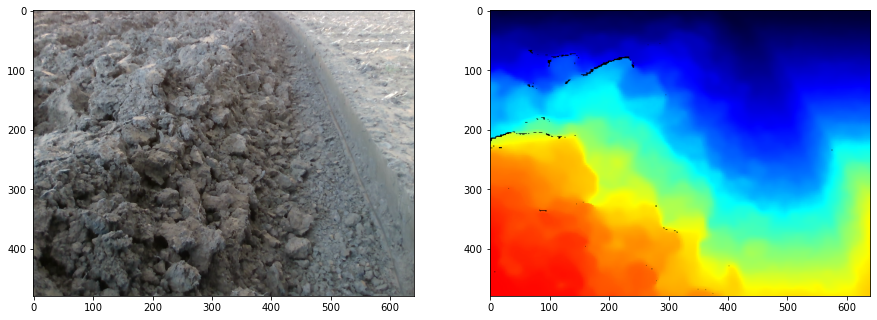

In [8]:
# folder_indices = list(range(8))
# folder_idx = str(random.choice(folder_indices))
# print("Folder choice:", folder_idx)
folder_idx = 6
folder = folders[folder_idx]

# file_indices = list(range(1, 16))
# frame_idx = str(random.choice(file_indices))
# print("Frame choice:", frame_idx)
frame_idx = 0

print("Fetching frame: {} from folder: {}".format(frame_idx+1, folder))
rgb_img, depth_img, depth_arr = triplets_per_folder[folder][frame_idx]

show_image_pairs(rgb_img, depth_img)

# frame: 13 from folder: frames/20201112_133434 (3) -> "Grayscale", "Sobel Vertical", "Threshold", "Hough Line"
# frame: 13 from folder: frames/20201112_140127 (6) -> "Grayscale", "Sobel Vertical", "Spatial Threshold", "Threshold", "Hough Line"

# Define Name-Method and Name-UI Mappings

Bind names to the methods and UI elements. Define new names and UI elements here if needed.

In [9]:
# Binding names to actual methods:
preproc_funcs = {
    "Grayscale": convert_grayscale,
    "Contrast": enhance_contrast,
    "Threshold": apply_threshold,
    "Adaptive Threshold": apply_adaptive_threshold,
    "Spatial Threshold": apply_spatial_threshold,
    "ROI Threshold": apply_roi_threshold,
    "Average Blur": apply_avg_blur,
    "Median Blur": apply_median_blur,
    "Bilateral Filter": apply_bilateral_filter,
    "Gaussian Blur": apply_gaussian_blur,  
    "Laplacian": apply_laplacian,
    "Sobel Vertical": apply_sobelv,
    "Sobel Horizontal": apply_sobelh,
}

detect_funcs = {
    "Canny Edges": apply_canny,
    "Contour": apply_contour,
    "Hough Line": apply_hough_line,
}

funcs = {**preproc_funcs, **detect_funcs}

# Defining UI elements for configurations
threshold_ui = lambda: interactive(threshold_config, thresh=(0,255), maxval=(0,255), 
                           type={"Binary": cv2.THRESH_BINARY,
                                 "Binary Inverted": cv2.THRESH_BINARY_INV,
                                 "Trunctate": cv2.THRESH_TRUNC,
                                 "To Zero": cv2.THRESH_TOZERO,
                                 "To Zero Inverted": cv2.THRESH_TOZERO_INV})
adaptive_threshold_ui = lambda: interactive(adaptive_threshold_config, 
                                       maxValue=(0,255), 
                                       adaptiveMethod={
                                           'Adaptive Gaussian Thresholding': cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           'Adaptive Mean Thresholding': cv2.ADAPTIVE_THRESH_MEAN_C},
                                       thresholdType={"Binary": cv2.THRESH_BINARY,
                                                      "Binary Inverted": cv2.THRESH_BINARY_INV,
                                                      "Trunctate": cv2.THRESH_TRUNC,
                                                      "To Zero": cv2.THRESH_TOZERO,
                                                      "To Zero Inverted": cv2.THRESH_TOZERO_INV},
                                       blockSize=(0,20),
                                       C=(0,20))
spatial_threshold_ui = lambda: interactive(spatial_threshold_config, 
                                           min_x=(0,1000), max_x=(0,1000),
                                           min_y=(0,1000), max_y=(0,1000))
avg_blur_ui = lambda: interactive(avg_blur_config, ksize=(1,20))
median_blur_ui = lambda: interactive(median_blur_config, ksize=(1,20))
bilateral_filter_ui = lambda: interactive(bilateral_filter_config, d=(1,20), sigmaColor=(1,100), sigmaSpace=(1,100))
gaussian_blur_ui = lambda: interactive(gaussian_blur_config, ksize=(1,20), sigmaX=(1,20))
laplacian_ui = lambda: interactive(laplacian_config, ksize=(1,20))
sobelv_ui = lambda: interactive(sobelv_config, ksize=(1,20))
sobelh_ui = lambda: interactive(sobelh_config, ksize=(1,20))
canny_ui = lambda: interactive(canny_config, threshold1=(0,100), threshold2=(0,100))
hough_line_ui = lambda: interactive(hough_line_config, threshold=(0,1000), min_theta=(0, 360), max_theta=(0, 360))

# Binding names to the configuration UI elements
preproc_ui = {
    "Grayscale": None,
    "Contrast": None,
    "ROI Threshold": None,
    "Threshold": threshold_ui,
    "Adaptive Threshold": adaptive_threshold_ui,
    "Spatial Threshold": spatial_threshold_ui,
    "Average Blur": avg_blur_ui,
    "Median Blur": median_blur_ui,
    "Bilateral Filter": bilateral_filter_ui,
    "Gaussian Blur": gaussian_blur_ui,
    "Laplacian": laplacian_ui,
    "Sobel Vertical": sobelv_ui,
    "Sobel Horizontal": sobelh_ui,
}

detect_ui = {
    "Canny Edges": canny_ui,
    "Contour": None,
    "Hough Line": hough_line_ui,
}

ui_elements = {**preproc_ui, **detect_ui}

# Create New Experiment

## Select Methods 

In [10]:
style = {
    'description_width': 'initial'
}

func_stack = []
add_buttons = []
log = Output(layout={'margin': '0px 50px 0px 50px', 'width': "200px"})

for item in ui_elements:
    button = Button(
        description=item,
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    )
    button.on_click(lambda e: push(func_stack, log, e))
    add_buttons.append(button)

pop_button = Button(
    description="Pop",
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
)
pop_button.on_click(lambda _: pop(func_stack, log))
    
menu1 = HBox([VBox(add_buttons), log, pop_button])

display(menu1)

## Configure Selected Methods

In [148]:
ui_instances = []
for i, k in enumerate(func_stack):
    if ui_elements[k]:
        print("{} {}:".format(i, k))
        ui_instance = ui_elements[k]()
        display(ui_instance)
        ui_instances.append(ui_instance)
    else:
        ui_instances.append(None)

## Apply Configured Methods

In [149]:
input_image = depth_img.copy() # rgb_img
roi_config = {}
NUM_CORNERS = 5

idx = -1
try:
    idx = func_stack.index("ROI Threshold")
except Exception:
    print("Info: ROI Threshold is not selected.")

if idx >= 0:
    matplotlib.use("Qt5Agg")
    roi_config["roi_corners"] = set_roi(input_image, NUM_CORNERS)
    print("Info: ROI Threshold is configured.")
    %matplotlib inline

Info: ROI Threshold is configured.


In [150]:
roi_config

{'roi_corners': array([[382,   1],
        [566, 478],
        [639, 478],
        [638,   0],
        [488,   1]], dtype=int32)}

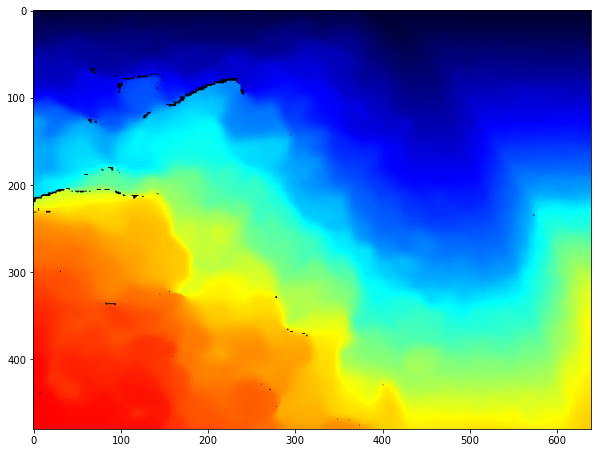

Converting to grayscale


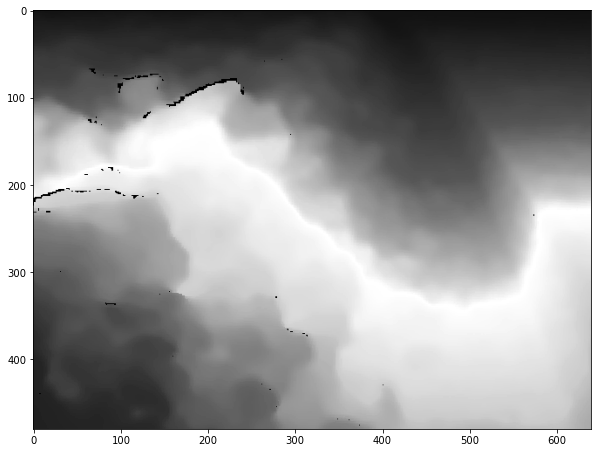

Applying Sobel filter for vertical edges (along y-axis) with args: {'ksize': 5}


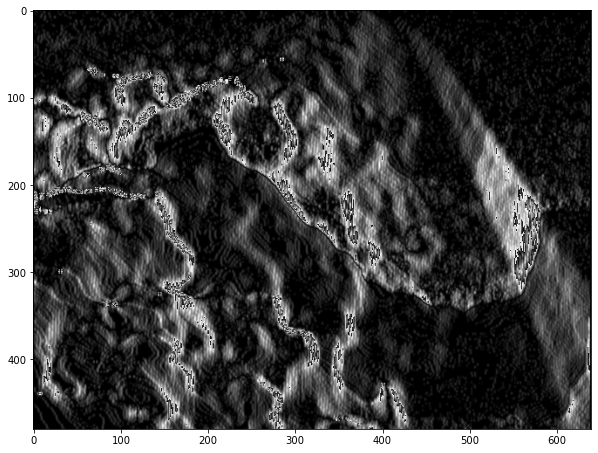

Applying bilateral filter with args: {'d': 7, 'sigmaColor': 50, 'sigmaSpace': 50}


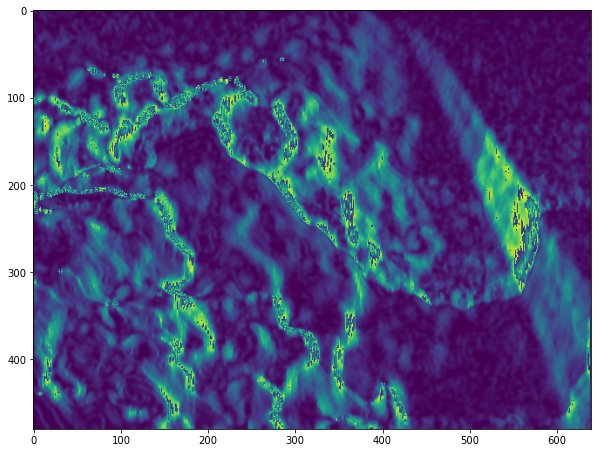

Applying canny with args: {'threshold1': 50, 'threshold2': 100}


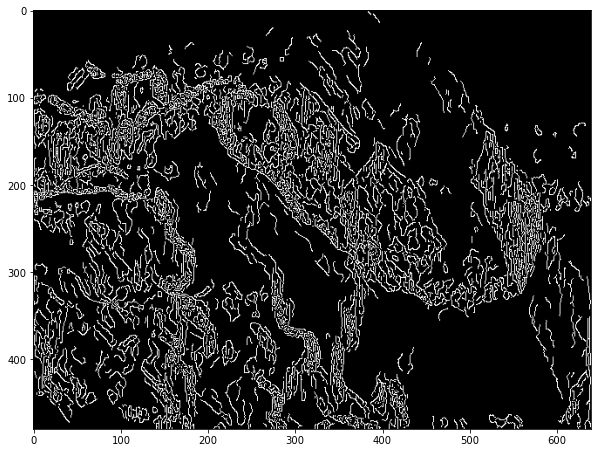

In [89]:
config_stack = []
# Update internal state
for ui_instance in ui_instances:
    config = {}
    if ui_instance:
        config = ui_instance.result
    config_stack.append(config)
if roi_config:
    config_stack[idx] = roi_config

input_image = depth_img.copy() # rgb_img
output = apply_functions(input_image.copy(), func_stack, config_stack)
# show_contours(input_image, output, contourIdx=0, cmap=None)

## Store Current Experiment

In [ ]:
text = Text(
    value='exp.json',
    placeholder='Enter a filename',
    description='Filename:',
    disabled=False
)


button = Button(
    description='Store',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

mini_form = HBox([text, button])

button.on_click(lambda _: save_config(text.value, func_stack, config_stack))

display(mini_form)

# Load Previous Experiment from File

In [ ]:
# TODO: Ability to continue with loaded experiment
config_stack = []
uploader_ui = FileUpload(
    accept='.json', # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_config(*uploader_ui.data, func_stack, config_stack), names='_counter')

display(uploader_ui)

In [ ]:
exps = []

def load_exp(json_contents, exps):
    for json_content in json_contents:
        exp = json.loads(json_content)
        exps.append((exp["func_stack"], exp["config_stack"]))
    

uploader_ui = FileUpload(
    accept='.json', # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_exp(uploader_ui.data, exps), names='_counter')

display(uploader_ui)

In [ ]:
input_image = depth_img # rgb_img
results = []

for exp in exps:
    result = apply_functions(input_image, *exp)
    results.append(result)

In [ ]:
show_contours(input_image, results[0], contourIdx=0, cmap=None)

In [ ]:
show_contours(rgb_img.copy(), results[0], contourIdx=0, cmap=None)

In [ ]:
# Merging Canny detector result with Hough line detector result
horizontal = results[0]
vertical = convert_coord2mask(horizontal.shape, results[1][0])
merged = horizontal | vertical
show_image(merged, cmap="gray")

# Aside: Experimental

In [ ]:
orig = depth_img
modified = orig.copy()
contours = apply_contour(modified) # List of N contour arrays of shape (C, 1, 2) to represent C-many 2D points
print(len(contours))
print(contours[0].shape)
print(contours[68].shape)
show_image(orig)
show_contours(modified, contours, contourIdx=-1)

In [ ]:
orig = depth_img
copy = orig.copy()
x = set_roi(orig, 10)

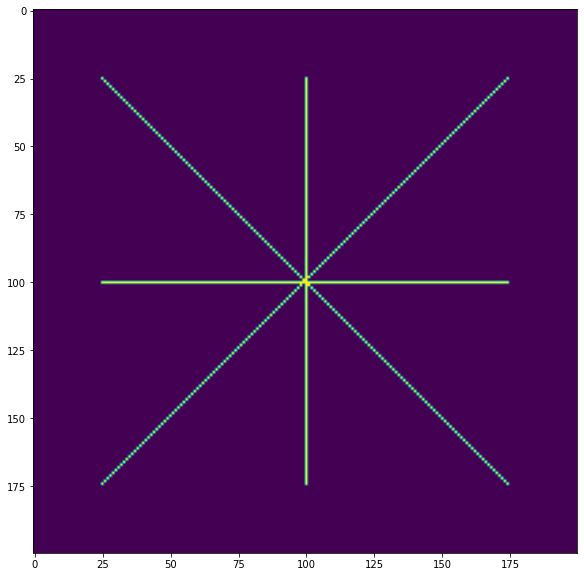

Applying Hough line with args: {'min_theta': -1.5707963267948966, 'max_theta': 1.5707963267948966, 'threshold': 0}


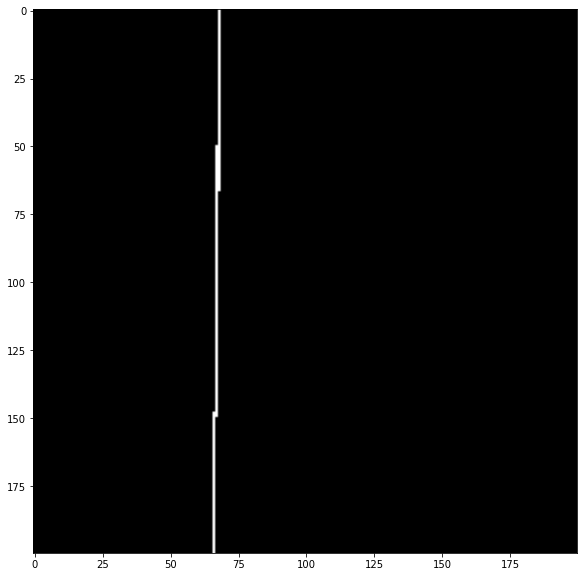

Applying Hough line (skimage) with args: {'min_theta': -90, 'max_theta': 90, 'threshold': 10, 'resolution': 1}
Warning!
Rho: 1.5026548672566378
Angle: -44.74860335195531


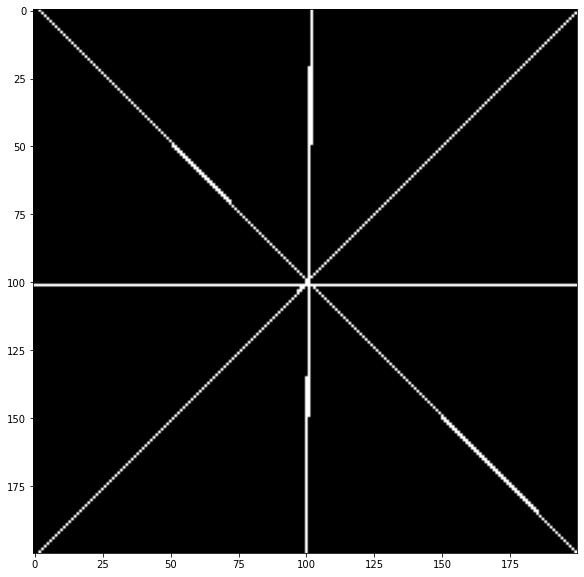

In [204]:
orig = depth_img
copy = orig.copy()


images = []

# apply_scharr(convert_grayscale(copy, visualize=False))
# apply_scharr(copy)
# apply_scharrh(copy, visualize=True)
# apply_scharrh(convert_grayscale(copy, visualize=True))
# apply_scharrv(convert_grayscale(copy, visualize=True))

# apply_farid(convert_grayscale(copy, visualize=False))
# apply_faridh(convert_grayscale(copy, visualize=False))
# apply_faridv(convert_grayscale(copy, visualize=False))

# # apply_prewitt(convert_grayscale(copy, visualize=False))
# apply_prewittv(convert_grayscale(copy, visualize=False))
# apply_prewitth(convert_grayscale(copy, visualize=False))

# x=filters.sobel_v(convert_grayscale(copy, visualize=False))
# show_image(np.abs(x), cmap="gray")
# l = apply_laplacian(convert_grayscale(copy, visualize=True), ksize=5)
# h = apply_sobelh(convert_grayscale(copy, visualize=True), ksize=5)
# v = apply_sobelv(convert_grayscale(copy, visualize=True), ksize=5)
# v = apply_roi_threshold(v, roi_corners=np.array([[382,   1],
#         [566, 478],
#         [639, 478],
#         [638,   0],
#         [488,   1]]))
# v = apply_threshold(v, thresh=127, maxval=255, type=0)

image = np.zeros((200, 200), dtype=np.uint8)
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255
image[100, idx] = 255
image[idx, 100] = 255
show_image(image)

line_pixels1 = apply_hough_line(image, min_theta=np.deg2rad(-90), max_theta=np.deg2rad(90), threshold=0)
line_pixels2 = apply_sk_hough_line(image, min_theta=-90, max_theta=90, threshold=10, resolution=1)

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
# dilated = cv2.dilate(v, kernel, iterations=1)
# closing = cv2.morphologyEx(v, cv2.MORPH_CLOSE, kernel)
# show_image(closing, cmap="gray")

# Set a precision of 0.5 degree.
# tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
# tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)
# h, theta, d = hough_line(v, theta=tested_angles)

# fig, axes = plt.subplots(1, 3, figsize=(15, 6))
# ax = axes.ravel()

# ax[0].imshow(v, cmap="gray")
# ax[0].set_title('Input image')
# ax[0].set_axis_off()

# ax[1].imshow(np.log(1 + h),
#              extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
#              cmap="gray", aspect=10)
# ax[1].set_title('Hough transform')
# ax[1].set_xlabel('Angles (degrees)')
# ax[1].set_ylabel('Distance (pixels)')
# ax[1].axis('image')

# ax[2].imshow(v, cmap="gray")
# origin = np.array((0, v.shape[1]))
# for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#     y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
#     ax[2].plot(origin, (y0, y1), '-r')
    
# ax[2].set_xlim(origin)
# ax[2].set_ylim((v.shape[0], 0))
# ax[2].set_axis_off()
# ax[2].set_title('Detected lines')

# plt.tight_layout()
# plt.show()

# mag = np.sqrt(h**2 + v**2).astype(np.uint8)
# show_image(mag, cmap="gray")
# print(x.max())
# print(x.min())
# print(y.max())
# print(y.min())

# y=apply_roberts(convert_grayscale(copy, visualize=False))
# print(y.max())
# print(y.min())

In [31]:
help(filters.sobel_v)

Help on function sobel_v in module skimage.filters.edges:

sobel_v(image, mask=None)
    Find the vertical edges of an image using the Sobel transform.
    
    Parameters
    ----------
    image : 2-D array
        Image to process.
    mask : 2-D array, optional
        An optional mask to limit the application to a certain area.
        Note that pixels surrounding masked regions are also masked to
        prevent masked regions from affecting the result.
    
    Returns
    -------
    output : 2-D array
        The Sobel edge map.
    
    Notes
    -----
    We use the following kernel::
    
      1   0  -1
      2   0  -2
      1   0  -1



In [ ]:
orig = depth_img
copy1 = orig.copy()
copy2 = orig.copy()

mask1 = np.zeros(copy1.shape, dtype=np.uint8)
mask2 = np.zeros(copy2.shape, dtype=np.uint8)
roi_corners = np.array([[(0, 0), (100,100), (50,0)]], dtype=np.int32)
C = copy.shape[2]
white = (255,) * C
cv2.fillPoly(mask1, roi_corners, color=white)
cv2.fillConvexPoly(mask2, roi_corners, color=white)
# from Masterfool: use cv2.fillConvexPoly if you know it's convex
image1 = cv2.bitwise_and(copy1, mask1)
image2 = cv2.bitwise_and(copy2, mask2)

show_image(image1)
show_image(image2)

In [ ]:
orig = depth_img
gray = convert_grayscale(orig)
edges1 = apply_laplacian(orig)
edges2 = apply_sobelx(orig)
edges3 = apply_sobely(orig)
show_image(gray, cmap="gray")
show_image(edges1, cmap="gray")
show_image(edges2, cmap="gray")
show_image(edges3, cmap="gray")

In [ ]:
# Inpainting
target = depth_img.copy()
mask = convert_grayscale(target, visualize=False)
mask = apply_threshold(mask, visualize=False, thresh=0, maxval=1, type=1)

show_image(mask, cmap="gray")

inpainted = cv2.inpaint(target, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

show_image(depth_img)
show_image(inpainted)

 # Help

## Coordinate Conventions of NumPy and OpenCV

Let us consider an arbitrary point P in the OpenCV coordinate system whose coordinates are (x, y). The same point in the NumPy image coordinate system is given by the coordinates (c, r).

Assume that we need to manipulate the image at point P and that the image is stored in the NumPy array img. OpenCV functions typically expect us to provide the coordinate information in the order **(x, y)** for its image manipulation functions. However, to access the element at point P using NumPy, we need to do **img[r, c]**.

### OpenCV Coordinates
---
![1st](notebook_images/opencv.png "OpenCV Coordinates")

### NumPy Coordinates
---
![2nd](notebook_images/numpy.png "NumPy Coordinates")

## cv2.COLOR_XXX

[cv2.COLOR_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ColorConversionCodes.html)

## cv2.THRESH_XXX

[Thresholding](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)

[cv2.THRESH_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ThresholdTypes.html)

## cv2.cvtColor

In [ ]:
help(cv2.cvtColor)

## cv2.equalizeHist

In [ ]:
help(cv2.equalizeHist)

## cv2.threshold

In [ ]:
help(cv2.threshold)

## cv2.adaptiveThreshold

In [ ]:
help(cv2.adaptiveThreshold)

## cv2.filter2D

In [ ]:
help(cv2.filter2D)

## cv2.blur

In [ ]:
help(cv2.blur)

## cv2.medianBlur

In [ ]:
help(cv2.medianBlur)

## cv2.bilateralFilter

In [ ]:
help(cv2.bilateralFilter)

## cv2.GaussianBlur

In [ ]:
help(cv2.GaussianBlur)

## cv2.Sobel

In [ ]:
help(cv2.Sobel)

## cv2.Laplacian

In [ ]:
help(cv2.Laplacian)

## cv2.Canny

All pixels having intensity between 1st and 2nd thresholds are flagged as weak and the Hysteresis mechanism will identify the ones that could be considered as strong and the ones that are considered as non-relevant.

In [ ]:
help(cv2.Canny)

## cv2.findContours

[Convex Hull](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#convex-hull)

[Fitting a Line](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#fitting-a-line)

[Mask and Pixel Points](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html#mask-and-pixel-points)

[Match Shapes](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/py_contours_more_functions.html#match-shapes)

In [ ]:
help(cv2.findContours)

## cv2.HoughLines

* If the line is passing below the origin, it will have a positive rho and an angle less than 180. If it is going above the origin, instead of taking an angle greater than 180, the angle is taken less than 180, and rho is taken negative. 
* Any vertical line will have 0 degree and horizontal lines will have 90 degree.

[Hough Transform Theory](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html#theory)

In [186]:
help(cv2.HoughLines)

Help on built-in function HoughLines:

HoughLines(...)
    HoughLines(image, rho, theta, threshold[, lines[, srn[, stn[, min_theta[, max_theta]]]]]) -> lines
    .   @brief Finds lines in a binary image using the standard Hough transform.
    .   
    .   The function implements the standard or standard multi-scale Hough transform algorithm for line
    .   detection. See <http://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm> for a good explanation of Hough
    .   transform.
    .   
    .   @param image 8-bit, single-channel binary source image. The image may be modified by the function.
    .   @param lines Output vector of lines. Each line is represented by a 2 or 3 element vector
    .   \f$(\rho, \theta)\f$ or \f$(\rho, \theta, \votes)\f$ . \f$\rho\f$ is the distance from the coordinate origin \f$(0,0)\f$ (top-left corner of
    .   the image). \f$\theta\f$ is the line rotation angle in radians (
    .   \f$0 \sim \textrm{vertical line}, \pi/2 \sim \textrm{horizontal line}\f$ ).
   

## cv2.inpaint

In [ ]:
help(cv2.inpaint)

## skimage.filters.scharr

In [ ]:
help(filters.scharr)
help(filters.scharr_v)
help(filters.scharr_h)

## skimage.filters.farid

In [ ]:
help(filters.farid)
help(filters.farid_v)
help(filters.farid_h)

## skimage.filters.roberts

In [ ]:
help(filters.roberts)

## Torchvision Models

[Available Model List](https://pytorch.org/docs/stable/torchvision/models.html)